# Tutorial on Propensity Score Matching with DoWhy to de-bias causal estimates

In this notebook we introduce the use of propensity score methods as provided by Microsoft's [DoWhy](https://microsoft.github.io/dowhy/readme.html) python library to estimate the magnitude of causal effects.

We illustrate this by estimating the causal effect of the material used as proppant (*treatment* variable) on the yearly output (*output*) of an oil well.

This example is based on work at Total Energy, see A. Bertoncello et al., "Using Causal Inference in Field Development Optimization: Application to Unconventional Plays", [Math Geosci (2020) 52:619–635](https://doi.org/10.1007/s11004-019-09847-z).

There are several *causal queries* that we may be interested in addressing, such as:
> What is the impact of using a ceramic material as proppant on the yearly production of an oil well?

or

> How much higher is the production of wells where ceramic proppant was used to what would have been a sand proppant been used instead?

We will focus on this latter question, which corresponds to estimating the *Average Treatment Effect on the Treated (ATT)*:

$𝐴𝑇𝑇
= 𝐸[𝑌(𝑇=1)−𝑌(𝑇=0)|𝑇=1]
= 𝐸[𝑌(𝑇=1)|𝑇=1]−𝐸[𝑌(𝑇=0)|𝑇=1]$

Note the *counterfactual* nature of this causal estimate:
- the first term on the right hand side is the average production by oils treated with ceramic proppant (T=1), a potentially observable quantity;
- the second term is the average production by oils treated with sand had they been treated with ceramic proppant: this cannot be observed, though we may have a control group or modelling strategy that provides a consistent estimate.

Answering this question amounts to answering the counterfactual question are: 
> What would have been the yearly production of an oil well kept with *ceramic* proppant (*treatment group*) if a *sand* proppant had been used instead?


The data of interest refers to the 5500+ oil wells by Total in the Marcellus plain in the USA, which are illustrated in the following image:

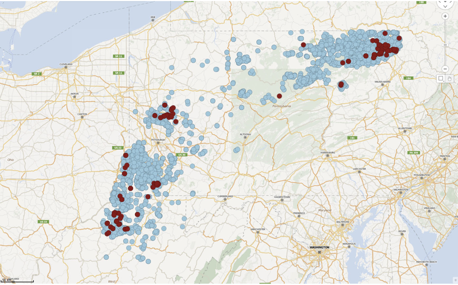

In [1]:
import IPython.display as ipd
ipd.Image(filename="images/oilwells_map_red.png", width=600)

In the image, wells maintained with *sand* proppant are indicated in light blue, and those with *ceramic* proppant in red.
 
Key properties of the sand and ceramic wells are summarized in the following table from the paper:

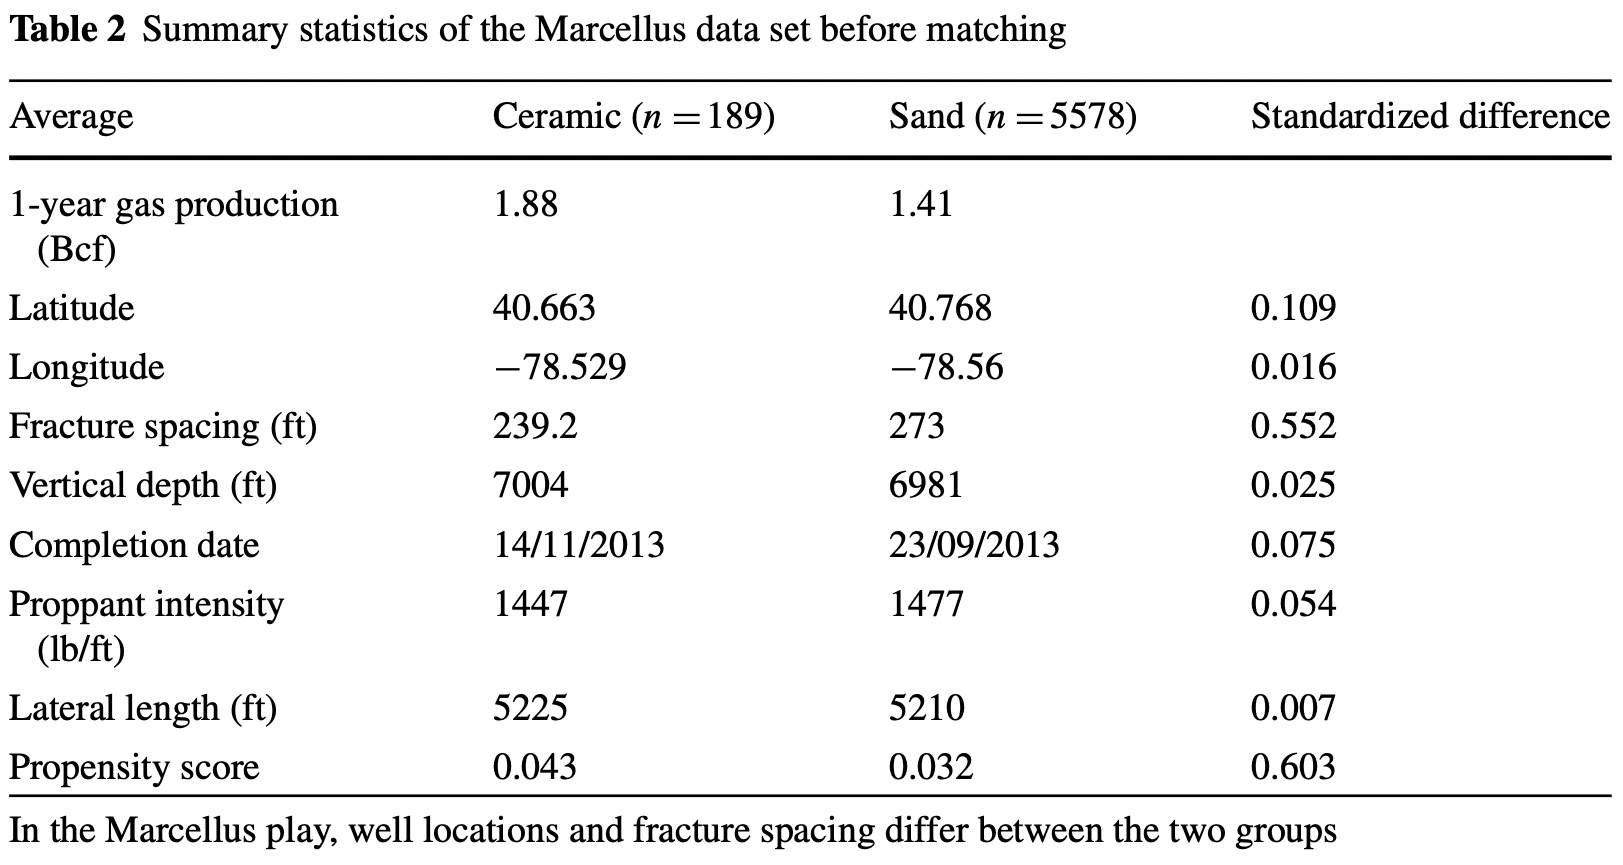

In [2]:
ipd.Image(filename="images/oilwells_table2.png", width=600)

The table shows that the two kinds of wells have differ in a number of properties, while the map makes it clear that they are not equally distributed geographically.

We will work below under the assumption that the geographical location is the key **confounder** in the analysis of the performance between the two kinds of wells.

## Load required packages and set debugging level



In [3]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
import sys

# install libgraphviz and pygraphviz for nicer-looking causal graphs:
!apt install libgraphviz-dev
!{sys.executable} -m pip install pygraphviz
import pygraphviz

# install dowhy
!{sys.executable} -m pip install dowhy
import dowhy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [5]:
filename = "wells.csv"
wells_df = pd.read_csv(filename)

wells_df.head()

,lon,lat,proppant,output,fspac,depth,length,pint
0,-75.899267,41.949756,0,1.403185,265.115381,6958.638348,5190.466959,1497.215261
1,-75.907491,41.917711,0,1.837230,229.852555,6974.246377,5296.163736,1450.330462
2,-75.949836,41.772259,0,1.959602,261.849687,6918.757744,5228.973846,1452.778178
3,-75.918724,41.894956,0,1.596191,265.024578,7125.098419,5341.870947,1506.788661
4,-75.342485,41.924296,0,1.636137,258.012150,6873.753886,5148.715585,1493.545926


In [6]:
wells_df.columns

Index(['lon', 'lat', 'proppant', 'output', 'fspac', 'depth', 'length', 'pint'], dtype='object')

Data columns:
- lon: longitude
- lat: latitude
- proppant: 0 (*sand*) or 1 (*ceramic*)
- fspac: fracture spacing (ft)
- depth: vertical depth (ft)
- length: lateral length (ft) 
- pint: proppant intensity (lbs/ft)
- output: 1-year production (bcf) [billion cubic feet]
- geometry: geopandas POINT for mapping


We explore the data corresponding to control (`proppant=0`, sand) and treatment (`proppant=1`, ceramic) groups to see if there are any obvious reasons to think that are not comparable/exchangeable.

This is akin to a the Table 2 from the paper ("Table 1" in medical papers):

In [7]:
wells_df.groupby('proppant').agg(['min', 'mean', 'max', 'std'])

lon                        ...         pint                        
                min       mean        max  ...         mean          max        std
proppant                                   ...                                     
0        -77.352843 -75.886973 -74.771365  ...  1476.977402  1604.036101  38.708571
1        -76.916082 -75.921978 -75.047182  ...  1447.468945  1579.246721  42.311423

[2 rows x 28 columns]

We observed some small differences in geographical distribution (`lat`itude and `lon`gitude variables), and on well `depth` and `pint`. 

Variables `output`, `fspac`, `length` display larger discrepancies, but just from the data we can't work out they are a cause or a consequence of the different `proppant` used, or just spurious correlations.

## Observational estimate

To start, we calculate the average output of wells where sand (`y0 = Y(T=0)`) and ceramic (`y1= Y(T=1)`) proppant was used, separately.

In [8]:
# Output of sand-drilled wells:
y1 = wells_df.loc[wells_df['proppant']==1, "output"].mean()
# Output of ceramic-drilled wells:
y0 = wells_df.loc[wells_df['proppant']==0, "output"].mean()
print("Observational average outputs: y1={:.2f} bcf  y0={:.2f} bcf".format(y1, y0))

Observational average outputs: y1=1.80 bcf  y0=1.26 bcf


Text(0, 0.5, '1-yr output (bcf)')

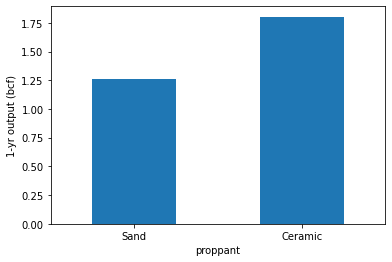

In [9]:
# Represent output by type of well:
ax = wells_df.groupby('proppant')['output'].mean().plot(
    kind='bar', legend=False)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0]= 'Sand'
labels[1]='Ceramic'
ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel("1-yr output (bcf)")

From these data, we calculate the *observational* estimate of the effect of proppant. If the assignment of sand or ceramic proppant had been done at random, this would be a good estimate of the causal effect of proppant on production, but generally it is a biased estimate.

In [10]:
est_obs = y1-y0
print("Observational estimate of effect: {:+.2f} bcf, or {:+.1%}".format(
    est_obs, est_obs/y0))

Observational estimate of effect: +0.54 bcf, or +42.8%


The observational estimate is that wells with ceramic proppant produce 0.54 bcf, or 43%, more output than those with sand output.

Indeed, a plot of the probability density function of production for sand and ceramic wells suggests that ceramic wells are centered around the maximum of production of sand wells:

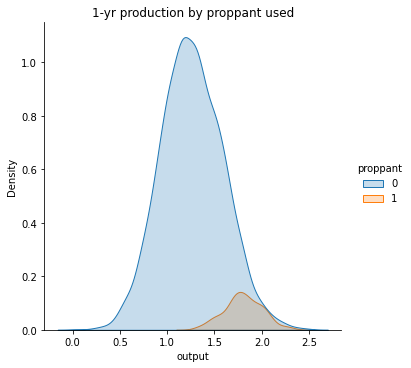

In [11]:
# Visually inspect PDF of well output
import seaborn as sns
p1 = sns.displot(wells_df, x="output", hue="proppant", #col="proppant",
                kind="kde", fill=True)
p1.set(title="1-yr production by proppant used")

savefig = True
savefig = False
if savefig:
    p1.savefig("oil_well_output_by_proppant.png", dpi=150)

## Causal estimate: Enter *DoWhy*
But was the assignment of proppant to wells at random?

We will next follow the four steps of causal inference to unravel the impact of potential confounding variables.

To find out a better, less biased estimate of the true causal impact of proppant material on output spend, we will use [DoWhy](https://microsoft.github.io/dowhy/readme.html).

### Building a causal model: Draw your causal graph

We first build a graph describing our assumptions of how different variables (features) affect each other, and in particular the yearly output.

Our assumptions, stemming from our business knowledge, are:
- the choice of `proppant` is influenced by the location (`lon`gitude and `lat`itude) of the well; this might reflect,*italicised text* e.g., different rock materials in different geographical locations (see `Unobserved confounders`);
- `proppant` choice in turns affects `depth` and `length` of the well, the fracture spacing (`fspac`), as well as the yearly `output`;
- `output` is also affected by all of `lon`, `lat`, `depth`, `length`, `fspac` and `proppant` choice.
- we include a vertex in the graph labelled `Unobserved confounders` to describe other features (e.g., rock composition, manager of each well, date of initial exploitation...) that may affect `lon`, `lat`, `depth`, `proppant` choice and yearly `output`.

In [12]:
# causal graph with only lon,lat as sufficient adjustment set:
causal_graph = """digraph {
treatment[label="T=proppant"];
output[label="Y=output"];
lon;
lat;
depth;
length;
U[label="Unobserved Confounders"];
lon -> treatment;
lat -> treatment;
lon -> output;
lat -> output;
treatment -> fspac;
treatment -> output;
treatment -> length;
treatment -> depth;
treatment -> fspac;
depth -> output;
length -> output;
fspac -> output;
U->treatment; U->output; U->lon; U->lat; U -> depth;
}"""

In [13]:
# introduce a column "treatment" that is the Boolean version of "proppant"
wells_df['treatment'] = wells_df['proppant'].astype(bool)
wells_df.head()

,lon,lat,proppant,output,fspac,depth,length,pint,treatment
0,-75.899267,41.949756,0,1.403185,265.115381,6958.638348,5190.466959,1497.215261,False
1,-75.907491,41.917711,0,1.837230,229.852555,6974.246377,5296.163736,1450.330462,False
2,-75.949836,41.772259,0,1.959602,261.849687,6918.757744,5228.973846,1452.778178,False
3,-75.918724,41.894956,0,1.596191,265.024578,7125.098419,5341.870947,1506.788661,False
4,-75.342485,41.924296,0,1.636137,258.012150,6873.753886,5148.715585,1493.545926,False


Next, create a CausalModel instance incorporading the data, and display the causal graph:

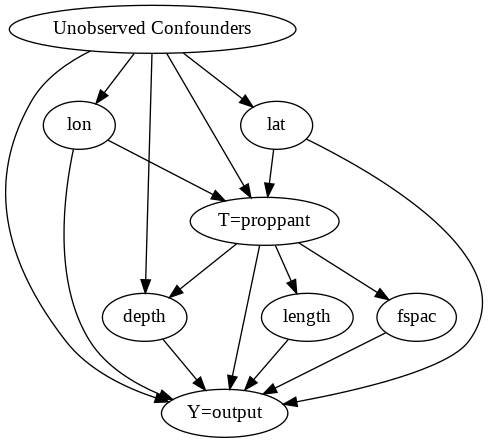

In [14]:
# Instantiate a causal model with the processed data and our causal graph:
model = dowhy.CausalModel(data=wells_df,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment", # <-- boolean if only two values
                     outcome="output")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Identify the estimand of the causal effect

After buiding our causal graph, we proceed with the Identification of possible Causal Estimands from the data available.

To proceed, we assume that `unobserved confounders` do not have an important impact to enable identifying the causal effect:

In [15]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(Expectation(output|lat,lon))
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,lat,lon,U) = P(output|treatment,lat,lon)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Here, DoWhy informs us that it has found an estimand of the causal effect using the  backdoor criterion: it is the difference in expectation values of output between treatment and control groups, fixing `lat` and `lon`:

$\frac{d}{dT} E[Y|lat, lon]$

which stands for:

$ATE = E[Y| T=1, lat,lon] - E[Y| T=0, lat,lon]$


### Numerical estimate of the causal effect: Matching

We now estimate the causal effect using *propensity score matching*, i.e., identifying datapoints with similar values of covariates and differing only in the value of `treatment` to estimate the causal effect.

Note that we ask `target_units="att"` to request the estimate of the ATT.

In [16]:
# Determine the causal estimate of the ATT
estimate_match = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att")
print(estimate_match)

print("Causal MATCH estimate of ATT: {:+.2f} bcf, or {:+.1%}".format(
    estimate_match.value, estimate_match.value/y0))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(Expectation(output|lat,lon))
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,lat,lon,U) = P(output|treatment,lat,lon)

## Realized estimand
b: output~treatment+lat+lon
Target units: att

## Estimate
Mean value: 0.19365245840914588

Causal MATCH estimate of ATT: +0.19 bcf, or +15.3%


We find $ATT=0.19$, i.e., ceramic wells produce 0.19 bcf more than sand wells, or a 15.3% higher productivity.

For completeness, we can also ask DoWhy to provide us with an estimate of the ATE:

$ ATE = E[Y(T=1)] - E[Y(T=0)]$  

In [17]:
# Determine the causal estimate of the ATE
estimate_match_ate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate")
print(estimate_match_ate)

print("Causal MATCH estimate of ATE: {:+.2f} bcf, or {:+.1%}".format(
    estimate_match_ate.value, estimate_match_ate.value/y0))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(Expectation(output|lat,lon))
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,lat,lon,U) = P(output|treatment,lat,lon)

## Realized estimand
b: output~treatment+lat+lon
Target units: ate

## Estimate
Mean value: 0.43243007048719206

Causal MATCH estimate of ATE: +0.43 bcf, or +34.2%


We observed that this estimate is much higher, ATE=0.43 bcf. Is this right?

In randomized controlled trials (RCTs), the ATT and ATE agree with each other, but this is not generally so for non-random samples.

More importantly, one needs to 
know exactly what DoWhy does under the hood to see the source of the discrepancy.
The way DoWhy calculates ATE is:

1. It first determines ATT and ATC (*average treatment effect on the control group*). To do that, for each T (C) unit if find a "nearby" C (T) unit using k-nearest neighbours (k=1) in the propensity-score space. 

  _DoWhy sets no maximum distance in the ps-space, so the nearest neighbour can be pretty far (i.e., a bad C (T) match)._

2. Then $ATE = (ATT*numtreatedunits + ATC*numcontrolunits) / ( numtreatedunits+numcontrolunits)$

 For the present problem, where *many* C units have not good T matches, the estimate of ATC is bad, and hence so is the estimate of ATE.

 We will see at the end that the probability density functions of propensity score for C(=sand) and T(=ceramic) wells are fairly different.

 Hence, instead of calling propensity_score_matching with  `target_units="ate"` we call it with `target_units="att"`.

### Numerical estimate of the causal effect: Propensity Score Stratification

A more advanced method of causal inference that is in particular more suitable than Matching for problems with many features is Propensity Score Stratification.

Here, we start by calculating the *propensity score*, i.e., the probability that a given unit (or row) in the sample would be assigned to the Treatment group given what we know about it ($X=\{lon, lat, depth, ...\}$): 

$ ps = P(T=1 | X)$

Then, we split the whole dataset into *strata* or groups of observations (in control or the treatment groups) with a similar propensity score. The idea is that assignment to T=0 or T=1 within a stratum is effectively at random, so that one can calculate a causal estimate for each stratum. In the end, weighting each stratum by the number of observations it contains, one obtains an overall estimate of the causal effect.

To start, as a reference let us get a rule-of-thumb estimate of the average propensity score, i.e., what is the probabilily on average to be assigned to the Treatment (or `ceramic`) group:

In [18]:
# Average probability of being assigned Treatment:
ntreat = len( wells_df[wells_df['proppant']==1] )
ncontrol = len( wells_df[wells_df['proppant']==0] )
ps_mean = ntreat / (ntreat + ncontrol)
print("Average propensity score = fraction of treated wells = {:.1%}".format(
    ps_mean))

Average propensity score = fraction of treated wells = 7.1%


When performing propensity score estimates, DoWhy allows us to fine-tune some parameters. For propensity score stratification, the relevant parameters are:

- `num_strata` (default: 50): number of strata in ps-space on which to split the dataset;
- `clipping_threshold` (default: 10): minimum number of units in a stratum.

DoWhy will  change the stratum limits in propensity score to satisfy these two constraints. For relatively small datasets, it may not be possible to satisfy both, and we'll need to decide to either reduce the  `num_strata` or `clipping_threshold`.

- `min_ps` and `max_ps` (default: 0.05 and 0.95): minimum and maximum acceptable ps values. Units with ps<`min_ps` or ps>`max_ps` will be excluded from any bins and any subsequent calculation.

For the present problem, an examination of the propensity score distributions (see below) suggests that `min_ps=0.10` is a good way to remove from the calculations all rows with very different values of covariates.

Because of the more sophisticated nature of propensity score stratification, we can see that this method is able to obtain virtually identical estimates for ATT and ATE:

In [19]:
# Determine the causal estimate of the ATE

min_ps, max_ps = 0.10, 0.60
num_strata = 30 # default: 50
clipping_threshold = 10 # default: 10

estimate_strat = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="att",
    confidence_intervals=True, # may slow down calculation a lot
    method_params={"min_ps_score": min_ps,
                   "max_ps_score": max_ps,
                   "num_strata": num_strata,
                   "clipping_threshold": clipping_threshold})

print(estimate_strat)

estimate_strat_ate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="ate",
    confidence_intervals=True, # may slow down calculation a lot
    method_params={"min_ps_score": min_ps,
                   "max_ps_score": max_ps,
                   "num_strata": num_strata,
                   "clipping_threshold": clipping_threshold})

print(estimate_strat_ate)

print("Causal STRATIFICATION estimate of ATT: {:+.2f} bcf, or {:+.1%}".format(
    estimate_strat.value, estimate_strat.value/y0))
print("Causal STRATIFICATION estimate of ATE: {:+.2f} bcf, or {:+.1%}".format(
    estimate_strat_ate.value, estimate_strat_ate.value/y0))

print("Recall observational estimate: {:+.2f} bcf, or {:+.1%}".format(
    est_obs, est_obs/y0))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(Expectation(output|lat,lon))
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,lat,lon,U) = P(output|treatment,lat,lon)

## Realized estimand
b: output~treatment+lat+lon
Target units: att

## Estimate
Mean value: 0.20550851912031332
95.0% confidence interval: (0.1812665173574489, 0.24529986023015496)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(Expectation(output|lat,lon))
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,lat,lon,U) = P(output|treatment,lat,lon)

## R

The causal estimate for the ATT is .21 bcf, with 95% confidence interval (0.17, 0.24) bcf, and for ATE is 0.21 bcf with 95% CI: (0.18, 0.25) bcf.

We note that:
- the central value of ATT and ATE estimates are the same, and also agree with the matching estimate for ATT. This gives us confidence in this result;
- these estimates have fairly narrow confidence internals, which notably *exclude* the earlier observational estimate.

In [20]:
# Using STRATIFICATION estimate from here onwards
estimate = estimate_strat
est_causal = estimate.value

### Refuting the causal estimate

We emphasize again that the causal estimate does not come from data alone. It comes from our assumptions (represented in the causal graph), which underpin the identification step. 

Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

A first-principles verification of assumptions is out of the question, but we can subject our results to a number of refutation attempts -- if all come back as expected, we gain confidence that our causal graph is a good representation of the situation in the real world.

We now describe some of the refutation methods available on DoWhy:

- *Placebo Treatment Refuter*: Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [21]:
# Note: default value for num_simulations = 100, which can take a long time
refute_placebo = model.refute_estimate(identified_estimand, 
                                   estimate, 
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", 
                                   num_simulations=2)
print(refute_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.20550851912031332
New effect:-0.004691212280487118
p value:0.00016477160039551908



We see that the new effect with the placebo treatment ($<0.1$ bcf) is much closer to zero than the original causal estimate ($\approx 0.21$ bcf), reinforcing our confidence that the latter was not the result of a random coincidence.

- *Random Common Cause*: Adds randomly drawn covariates to the data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [22]:
refute_common_cause = model.refute_estimate(identified_estimand, 
                                            estimate,
                                            method_name="random_common_cause")
print(refute_common_cause)

Refute: Add a Random Common Cause
Estimated effect:0.20550851912031332
New effect:0.20686840345806792



The new causal estimate is similar to the original one (within the 95% confidence interval, and much smaller than the observational one) which suggests that the result is robust to adding/removing random noise.

- *Data Subset Refuter*: Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [23]:
# Note: default value for num_simulations = 100, which can take a long time
refute_subset = model.refute_estimate(identified_estimand, 
                                      estimate,
                                      method_name="data_subset_refuter",
                                      num_simulations=3)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.20550851912031332
New effect:0.2103398340819704
p value:0.2931880213121438



The causal estimate based on a subset of the data is very close to the original one, reinforcing our confidence in it.

### Conclusion:
We see that our estimate passes all three refutation tests. This does not prove its correctness, but it increases confidence that the estimate is not the result of random coincidence.

Importantly, this does not by itself confirm the validity of the causal graph. Estimates based on another causal graph could also pass the refutation tests and yield a different numerical estimate for ATE or ATT.

## Advanced: Analysis of the distribution of propensity scores

The CausalModel object contains the propensity scores calculated for each row. We proceed now to analyse them to gain further understanding of the source of the discrepancy between observational and causal estimates.


In [24]:
#print("Recall the fraction of wells that were treated is ", num_cer/num_wells)
ntreat = len( wells_df[wells_df['proppant']==1] )
ncontrol = len( wells_df[wells_df['proppant']==0] )
ps_mean = ntreat/(ntreat + ncontrol)
print("Recall the fraction of wells that were treated is {}/{}={:.3f}".format( 
      ntreat, (ntreat + ncontrol), ps_mean ))

# We can take a look at the propensity scores:
print(
    estimate.propensity_scores.aggregate(['min', 'mean', 'max'])
)


Recall the fraction of wells that were treated is 284/4003=0.071
min     0.001071
mean    0.070947
max     0.729633
Name: propensity_score, dtype: float64


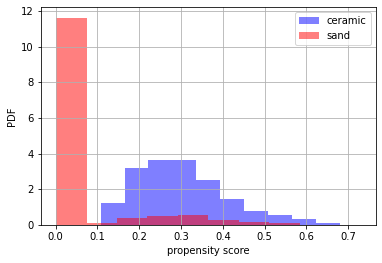

In [25]:
# Plotting the probability density function of propensity scores:
idx_sand = wells_df.index[ wells_df['proppant']==0 ]
idx_cer = wells_df.index[ wells_df['proppant']==1 ]

ps_cer = estimate.propensity_scores.loc[idx_cer]
ps_sand = estimate.propensity_scores.loc[idx_sand]

fig, ax = plt.subplots(1,1)
ps_cer.hist(ax=ax, color='blue', alpha=0.5, label='ceramic', density=True)
ps_sand.hist(ax=ax, color='red', alpha=0.5, label='sand', density=True)
plt.legend()
plt.xlabel('propensity score')
plt.ylabel('PDF');

We observe that there is a large number of `sand` datapoints with very low propensity score. This conform a rather specific peak, while there appears to be good overlap between `sand` and `ceramic` data elsewhere.


We determine a threshold ps value to separate these two regions:

Ceramic ps: min, max = 0.11 0.68
Sand ps: min, max =    0.00 0.73
  ps threshold: 0.10742448278635695
 Number of ceramic wells:  284
 Number of sand wells with ps>ps_{thr}:  558


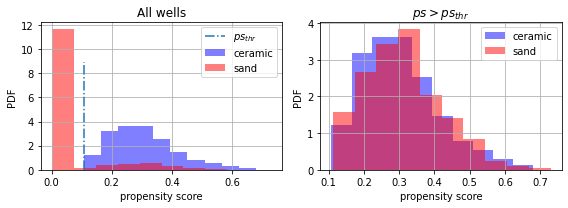

In [26]:
# thresdhold ps:
ps_thr = np.max([ps_cer.min(), ps_sand.min()])
# ps for sand data above the threshold:
ps_sand_1 = ps_sand [ps_sand>ps_thr]

print("Ceramic ps: min, max = {:.2f} {:.2f}".format(ps_cer.min(), ps_cer.max()))
print("Sand ps: min, max =    {:.2f} {:.2f}".format(ps_sand.min(), ps_sand.max()))
print("  ps threshold:", ps_thr)

print(" Number of ceramic wells: ", len(ps_cer))
print(" Number of sand wells with ps>ps_{thr}: ", len(ps_sand_1))

# plot ps PDFs for data above the threshold:
#fig, ax = plt.subplots(1,1)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,3))
ps_cer.hist(ax=ax0, color='blue', alpha=0.5, label='ceramic', density=True)
ps_sand.hist(ax=ax0, color='red', alpha=0.5, label='sand', density=True)
ax0.axvline(x=ps_thr, ymin=0, ymax=ps_sand.max(), linestyle='-.', label='$ps_{thr}$')
ax0.set_xlabel('propensity score')
ax0.set_ylabel('PDF');
ax0.set_title('All wells');
ax0.legend()
ps_cer.hist(ax=ax1, color='blue', alpha=0.5, label='ceramic', density=True)
ps_sand_1.hist(ax=ax1, color='red', alpha=0.5, label='sand', density=True)
ax1.set_xlabel('propensity score')
ax1.set_ylabel('PDF');
ax1.set_title('$ps>ps_{thr}$');
plt.legend()
#plt.xlabel('propensity score')
#plt.ylabel('PDF');
fig.tight_layout() #pad=3.0)

saveplot = False
if saveplot:
    fig.savefig("oil_wells_ps.png", dpi=150)

The distribution above the threshold is very similar which suggests that, in this region of PS, assignment to `sand` or `ceramic` is as if it had happened at random (even though there are twice as many `sand` wells in this region than `ceramic` wells!)